# L1

Iteration 1, Log-Likelihood: -38.66962419827348
Iteration 2, Log-Likelihood: -38.60519089279225
Iteration 3, Log-Likelihood: -38.52482836488678
Iteration 4, Log-Likelihood: -38.41757560241345
Iteration 5, Log-Likelihood: -38.272207915327506
Iteration 6, Log-Likelihood: -38.07719269998475
Iteration 7, Log-Likelihood: -37.822642513670836
Iteration 8, Log-Likelihood: -37.50404003380306
Iteration 9, Log-Likelihood: -37.12676860044183
Iteration 10, Log-Likelihood: -36.707930488688554
Iteration 11, Log-Likelihood: -36.26983730042377
Iteration 12, Log-Likelihood: -35.822360514122096
Iteration 13, Log-Likelihood: -35.338800687876
Iteration 14, Log-Likelihood: -34.732319338824375
Iteration 15, Log-Likelihood: -33.838308333981274
Iteration 16, Log-Likelihood: -32.450348278601965
Iteration 17, Log-Likelihood: -30.56684794552564
Iteration 18, Log-Likelihood: -28.68116939367915
Iteration 19, Log-Likelihood: -27.28951338598389
Iteration 20, Log-Likelihood: -26.384453114597306
Iteration 21, Log-Likel

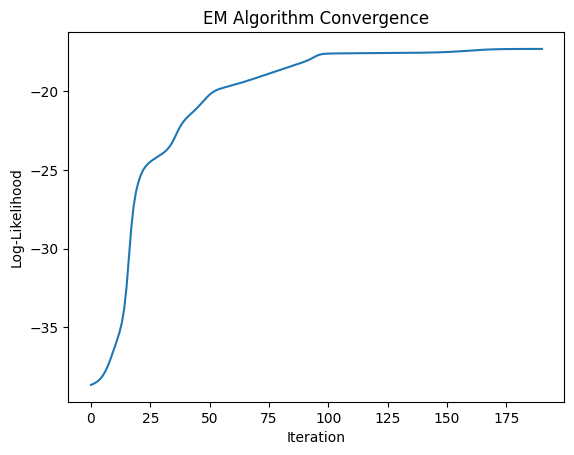

In [5]:
import numpy as np
from scipy.stats import multivariate_normal

# Generate some dummy data (replace with your actual N1, N2 values)
np.random.seed(42)
N = 100  # Number of samples
D = 2    # Dimension (N1, N2)
K = 3    # Number of latent components

# Initialize random data
data = np.random.rand(N, D)

# Initialize parameters
pi = np.ones(K) / K  # Equal priors
mu = np.random.rand(K, D)  # Random means
sigma = np.array([np.eye(D) for _ in range(K)])  # Identity covariance matrices

def e_step(data, pi, mu, sigma, K):
    N = data.shape[0]
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k])
    gamma = gamma / gamma.sum(axis=1, keepdims=True)  # Normalize
    return gamma

def m_step(data, gamma, K):
    N, D = data.shape
    Nk = gamma.sum(axis=0)
    pi = Nk / N
    mu = np.array([np.sum(gamma[:, k, None] * data, axis=0) / Nk[k] for k in range(K)])
    sigma = np.array([
        np.sum(gamma[:, k, None, None] * 
               np.einsum('ni,nj->nij', data - mu[k], data - mu[k]), axis=0) / Nk[k]
        for k in range(K)
    ])
    return pi, mu, sigma

def log_likelihood(data, pi, mu, sigma, K):
    likelihood = 0
    for k in range(K):
        likelihood += pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k])
    return np.sum(np.log(likelihood))

# EM algorithm
tol = 1e-4
max_iter = 300
prev_ll = None

log_likelihoods = []

for iteration in range(max_iter):
    # E-step
    gamma = e_step(data, pi, mu, sigma, K)
    
    # M-step
    pi, mu, sigma = m_step(data, gamma, K)
    
    # Compute log-likelihood
    ll = log_likelihood(data, pi, mu, sigma, K)
    if prev_ll is not None and abs(ll - prev_ll) < tol:
        break
    prev_ll = ll
    log_likelihoods.append(ll)
    print(f"Iteration {iteration + 1}, Log-Likelihood: {ll}")

# Output the latent variables (responsibilities)
print("Final responsibilities (gamma):")
print(gamma)


# Plot log-likelihoods
import matplotlib.pyplot as plt
plt.plot(log_likelihoods)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("EM Algorithm Convergence")
plt.show()


# L2

Prior probabilities (pi):
[0.68527617 0.16479062 0.14993321]

Conditional probabilities P(C1 | L2):
[[0.17270653 0.4369502  0.39034327]
 [0.73249966 0.01225698 0.25524335]
 [0.60653177 0.39049793 0.0029703 ]]

Conditional probabilities P(C2 | L2):
[[0.26180797 0.09294858 0.40946389 0.23577956]
 [0.21909368 0.11452965 0.26104792 0.40532874]
 [0.02991102 0.71652664 0.10928802 0.14427432]]


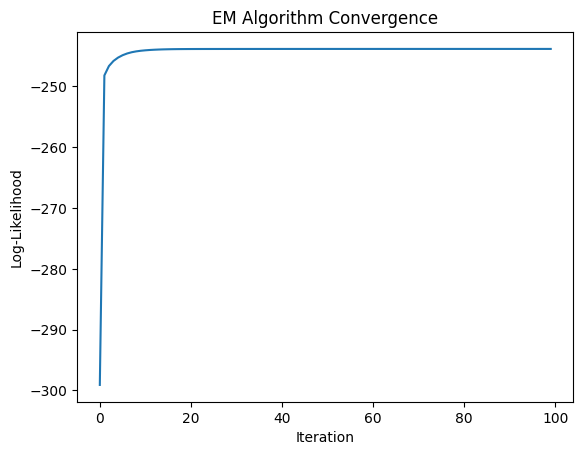

In [1]:
import numpy as np
from scipy.special import logsumexp

# Initialize data (categorical features C1 and C2 as integers)
# Assume C1 and C2 are one-hot encoded or converted to integer categories
np.random.seed(42)  # For reproducibility
C1 = np.random.randint(0, 3, 100)  # 3 categories for C1
C2 = np.random.randint(0, 4, 100)  # 4 categories for C2

# Combine C1 and C2 into a dataset
data = np.column_stack((C1, C2))

# Number of latent classes for L2
K = 3  # Assume 3 latent classes

# Number of unique categories in C1 and C2
num_categories_C1 = len(np.unique(C1))
num_categories_C2 = len(np.unique(C2))

# Initialize parameters
pi = np.random.dirichlet([1] * K)  # Prior probabilities of L2
P_C1_given_L2 = np.random.dirichlet([1] * num_categories_C1, size=K)  # P(C1 | L2)
P_C2_given_L2 = np.random.dirichlet([1] * num_categories_C2, size=K)  # P(C2 | L2)

# Number of data points
N = data.shape[0]

# EM algorithm
def em_algorithm(data, K, max_iter=100, tol=1e-6):
    global pi, P_C1_given_L2, P_C2_given_L2

    log_likelihoods = []

    for iteration in range(max_iter):
        # E-Step: Compute responsibilities (posterior probabilities)
        log_responsibilities = np.zeros((N, K))

        for k in range(K):
            log_responsibilities[:, k] = (
                np.log(pi[k]) +
                np.log(P_C1_given_L2[k, data[:, 0]]) +
                np.log(P_C2_given_L2[k, data[:, 1]])
            )

        # Normalize responsibilities in log space to avoid underflow
        log_norm = logsumexp(log_responsibilities, axis=1, keepdims=True)
        log_responsibilities -= log_norm
        responsibilities = np.exp(log_responsibilities)

        # Compute log-likelihood
        log_likelihood = np.sum(log_norm)
        log_likelihoods.append(log_likelihood)

        # M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)  # Effective number of points in each class

        # Update pi (prior probabilities)
        pi = N_k / N

        # Update P(C1 | L2) and P(C2 | L2)
        for k in range(K):
            for c in range(num_categories_C1):
                P_C1_given_L2[k, c] = np.sum(responsibilities[data[:, 0] == c, k])

            for c in range(num_categories_C2):
                P_C2_given_L2[k, c] = np.sum(responsibilities[data[:, 1] == c, k])

            # Normalize probabilities
            P_C1_given_L2[k, :] /= N_k[k]
            P_C2_given_L2[k, :] /= N_k[k]

        # Check for convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break

    return pi, P_C1_given_L2, P_C2_given_L2, log_likelihoods

# Run the EM algorithm
pi, P_C1_given_L2, P_C2_given_L2, log_likelihoods = em_algorithm(data, K)

# Output the results
print("Prior probabilities (pi):")
print(pi)
print("\nConditional probabilities P(C1 | L2):")
print(P_C1_given_L2)
print("\nConditional probabilities P(C2 | L2):")
print(P_C2_given_L2)

# Plot log-likelihoods
import matplotlib.pyplot as plt
plt.plot(log_likelihoods)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("EM Algorithm Convergence")
plt.show()


# L1 and L2


L2 Prior probabilities (pi):
[0.68527617 0.16479062 0.14993321]

L2 Conditional probabilities P(C1 | L2):
[[0.17270653 0.4369502  0.39034327]
 [0.73249966 0.01225698 0.25524335]
 [0.60653177 0.39049793 0.0029703 ]]

L2 Conditional probabilities P(C2 | L2):
[[0.26180797 0.09294858 0.40946389 0.23577956]
 [0.21909368 0.11452965 0.26104792 0.40532874]
 [0.02991102 0.71652664 0.10928802 0.14427432]]

L1 Prior probabilities (pi):
[0.3778142  0.36254772 0.25963807]

L1 Means:
[[ 0.49143389 -0.58663821]
 [ 0.07227631  0.32435912]
 [-0.37797355  1.20033628]]

L1 Covariances:
[[[0.58222945 0.21161466]
  [0.21161466 0.30943108]]

 [[0.99406406 0.63155778]
  [0.63155778 0.5864356 ]]

 [[0.74784033 0.15997339]
  [0.15997339 0.42184517]]]


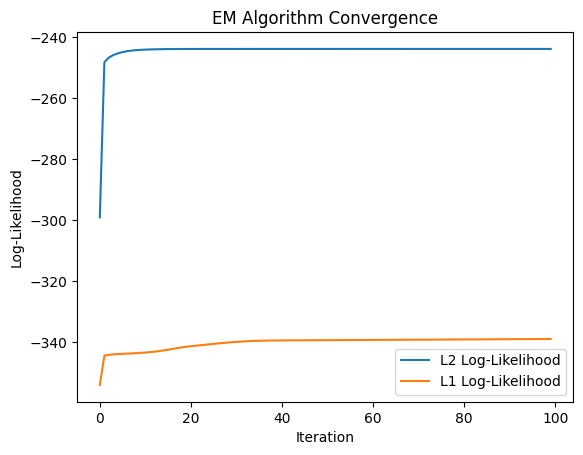

In [23]:
import numpy as np
from scipy.special import logsumexp

# Initialize data (categorical features C1 and C2 as integers)
# Assume C1 and C2 are one-hot encoded or converted to integer categories
np.random.seed(42)  # For reproducibility
C1 = np.random.randint(0, 3, 100)  # 3 categories for C1
C2 = np.random.randint(0, 4, 100)  # 4 categories for C2

# Combine C1 and C2 into a dataset
data_categorical = np.column_stack((C1, C2))

# Number of latent classes for L2
K_L2 = 3  # Assume 3 latent classes

# Number of unique categories in C1 and C2
num_categories_C1 = len(np.unique(C1))
num_categories_C2 = len(np.unique(C2))

# Initialize parameters for L2
pi_L2 = np.random.dirichlet([1] * K_L2)  # Prior probabilities of L2
P_C1_given_L2 = np.random.dirichlet([1] * num_categories_C1, size=K_L2)  # P(C1 | L2)
P_C2_given_L2 = np.random.dirichlet([1] * num_categories_C2, size=K_L2)  # P(C2 | L2)

# Initialize data for numerical features (L1 dependencies)
N = data_categorical.shape[0]  # Number of data points
num_features_L1 = 2
numerical_data = np.random.randn(N, num_features_L1)  # N1, N2 numerical features

# Number of latent components for L1
K_L1 = 3  # Assume 2 latent components for L1

# Initialize parameters for L1
pi_L1 = np.random.dirichlet([1] * K_L1)  # Prior probabilities of L1
means_L1 = np.random.randn(K_L1, num_features_L1)  # Means for L1 Gaussian components
covariances_L1 = np.array([np.eye(num_features_L1) for _ in range(K_L1)])  # Covariance matrices for L1

# EM algorithm for L2
def em_algorithm_L2(data, K, max_iter=100, tol=1e-6):
    global pi_L2, P_C1_given_L2, P_C2_given_L2

    log_likelihoods = []

    for iteration in range(max_iter):
        # E-Step: Compute responsibilities (posterior probabilities)
        log_responsibilities = np.zeros((N, K))

        for k in range(K):
            log_responsibilities[:, k] = (
                np.log(pi_L2[k]) +
                np.log(P_C1_given_L2[k, data[:, 0]]) +
                np.log(P_C2_given_L2[k, data[:, 1]])
            )

        # Normalize responsibilities in log space to avoid underflow
        log_norm = logsumexp(log_responsibilities, axis=1, keepdims=True)
        log_responsibilities -= log_norm
        responsibilities = np.exp(log_responsibilities)

        # Compute log-likelihood
        log_likelihood = np.sum(log_norm)
        log_likelihoods.append(log_likelihood)

        # M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)  # Effective number of points in each class

        # Update pi (prior probabilities)
        pi_L2 = N_k / N

        # Update P(C1 | L2) and P(C2 | L2)
        for k in range(K):
            for c in range(num_categories_C1):
                P_C1_given_L2[k, c] = np.sum(responsibilities[data[:, 0] == c, k])

            for c in range(num_categories_C2):
                P_C2_given_L2[k, c] = np.sum(responsibilities[data[:, 1] == c, k])

            # Normalize probabilities
            P_C1_given_L2[k, :] /= N_k[k]
            P_C2_given_L2[k, :] /= N_k[k]

        # Check for convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break

    return pi_L2, P_C1_given_L2, P_C2_given_L2, log_likelihoods, responsibilities

# EM algorithm for L1 with influence from L2
def em_algorithm_L1(numerical_data, responsibilities_L2, K, max_iter=100, tol=1e-6):
    global pi_L1, means_L1, covariances_L1

    log_likelihoods = []

    for iteration in range(max_iter):
        # E-Step: Compute responsibilities (posterior probabilities for L1)
        log_responsibilities = np.zeros((N, K))

        for k in range(K):
            diff = numerical_data - means_L1[k]
            mahalanobis = np.sum(diff @ np.linalg.inv(covariances_L1[k]) * diff, axis=1)
            log_responsibilities[:, k] = (
                np.log(pi_L1[k]) -
                0.5 * (mahalanobis + np.log(np.linalg.det(covariances_L1[k])) + num_features_L1 * np.log(2 * np.pi))
            )

        # Incorporate influence from L2 responsibilities
        L2_influence = (responsibilities_L2 @ pi_L2[:, None]).flatten()  # Shape (N,)
        log_responsibilities += np.log(L2_influence)[:, None]  # Broadcast across K_L1

        # Normalize responsibilities in log space
        log_norm = logsumexp(log_responsibilities, axis=1, keepdims=True)
        log_responsibilities -= log_norm
        responsibilities = np.exp(log_responsibilities)

        # Compute log-likelihood
        log_likelihood = np.sum(log_norm)
        log_likelihoods.append(log_likelihood)

        # M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)  # Effective number of points in each component

        # Update pi (prior probabilities for L1)
        pi_L1 = N_k / N

        # Update means
        for k in range(K):
            means_L1[k] = np.sum(responsibilities[:, k, None] * numerical_data, axis=0) / N_k[k]

        # Update covariances
        for k in range(K):
            diff = numerical_data - means_L1[k]
            covariances_L1[k] = (responsibilities[:, k, None, None] * np.einsum('ij,ik->ijk', diff, diff)).sum(axis=0) / N_k[k]

        # Check for convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break

    return pi_L1, means_L1, covariances_L1, log_likelihoods, responsibilities

# Run the EM algorithm for L2
pi_L2, P_C1_given_L2, P_C2_given_L2, log_likelihoods_L2, responsibilities_L2 = em_algorithm_L2(data_categorical, K_L2)

# Run the EM algorithm for L1 with influence from L2
pi_L1, means_L1, covariances_L1, log_likelihoods_L1, responsibilities_L1 = em_algorithm_L1(numerical_data, responsibilities_L2, K_L1)

# Output the results
print("\nL2 Prior probabilities (pi):")
print(pi_L2)
print("\nL2 Conditional probabilities P(C1 | L2):")
print(P_C1_given_L2)
print("\nL2 Conditional probabilities P(C2 | L2):")
print(P_C2_given_L2)

print("\nL1 Prior probabilities (pi):")
print(pi_L1)
print("\nL1 Means:")
print(means_L1)
print("\nL1 Covariances:")
print(covariances_L1)

# Plot log-likelihoods for both L1 and L2
import matplotlib.pyplot as plt
plt.plot(log_likelihoods_L2, label="L2 Log-Likelihood")
plt.plot(log_likelihoods_L1, label="L1 Log-Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.title("EM Algorithm Convergence")
plt.show()


# T numerical

In [26]:
# Extend the EM algorithm to include learning for T
def em_algorithm_T_numerical(data_numerical, data_categorical, T, responsibilities_L1, responsibilities_L2):
    # Initialize parameters for T
    global T_means, T_variances
    T_means = np.zeros((K_L1, K_L2))
    T_variances = np.ones((K_L1, K_L2))

    # Update T parameters based on responsibilities
    for l1 in range(K_L1):
        for l2 in range(K_L2):
            # Compute weights
            weights = responsibilities_L1[:, l1] * responsibilities_L2[:, l2]
            weights /= weights.sum()  # Normalize weights
            
            # Conditional mean and variance of T
            T_means[l1, l2] = np.sum(weights * T) / np.sum(weights)
            T_variances[l1, l2] = np.sum(weights * (T - T_means[l1, l2])**2) / np.sum(weights)

    return T_means, T_variances

# Function to predict T using the learned parameters
def predict_T_from_data(N1, N2, C1, C2):
    # Combine input features
    numerical_data = np.array([[N1, N2]])
    categorical_data = np.array([[C1, C2]])

    # Infer responsibilities for L1
    log_responsibilities_L1 = np.zeros((1, K_L1))
    for k in range(K_L1):
        diff = numerical_data - means_L1[k]
        mahalanobis = np.sum(diff @ np.linalg.inv(covariances_L1[k]) * diff, axis=1)
        log_responsibilities_L1[:, k] = (
            np.log(pi_L1[k]) -
            0.5 * (mahalanobis + np.log(np.linalg.det(covariances_L1[k])) + num_features_L1 * np.log(2 * np.pi))
        )
    responsibilities_L1 = np.exp(log_responsibilities_L1 - logsumexp(log_responsibilities_L1))

    # Infer responsibilities for L2
    log_responsibilities_L2 = np.zeros((1, K_L2))
    for k in range(K_L2):
        log_responsibilities_L2[:, k] = (
            np.log(pi_L2[k]) +
            np.log(P_C1_given_L2[k, categorical_data[:, 0]]) +
            np.log(P_C2_given_L2[k, categorical_data[:, 1]])
        )
    responsibilities_L2 = np.exp(log_responsibilities_L2 - logsumexp(log_responsibilities_L2))

    # Predict T using the expected value
    expected_T = 0
    for l1 in range(K_L1):
        for l2 in range(K_L2):
            weight = responsibilities_L1[0, l1] * responsibilities_L2[0, l2]
            expected_T += weight * T_means[l1, l2]

    return expected_T

# Example dataset
N = 100
T = np.random.randn(N)  # True values of T
# Update the parameters for T based on the data and responsibilities
T_means, T_variances = em_algorithm_T_numerical(numerical_data, data_categorical, T, responsibilities_L1, responsibilities_L2)

# Example prediction
N1, N2 = 0.5, -1.2  # Example numerical features
C1, C2 = 1, 2       # Example categorical features
predicted_T = predict_T_from_data(N1, N2, C1, C2)
print(f"Predicted T: {predicted_T}")


Predicted T: -0.12591973700313264


# T categorical

In [27]:
# Assume T has C_T categories
C_T = 3  # Number of categories for T
P_T_given_L1_L2 = np.random.dirichlet([1] * C_T, size=(K_L1, K_L2))  # Initialize P(T | L1, L2)

# Extend the EM algorithm to learn P(T | L1, L2)
def em_algorithm_categorical_T(T, responsibilities_L1, responsibilities_L2):
    global P_T_given_L1_L2

    # Update P(T | L1, L2) based on responsibilities
    for l1 in range(K_L1):
        for l2 in range(K_L2):
            # Compute weights
            weights = responsibilities_L1[:, l1] * responsibilities_L2[:, l2]
            
            # Update probabilities for each category of T
            for t in range(C_T):
                P_T_given_L1_L2[l1, l2, t] = np.sum(weights[T == t])

            # Normalize probabilities
            P_T_given_L1_L2[l1, l2, :] /= np.sum(P_T_given_L1_L2[l1, l2, :])

    return P_T_given_L1_L2

# Function to predict T using the learned parameters
def predict_categorical_T(N1, N2, C1, C2):
    # Combine input features
    numerical_data = np.array([[N1, N2]])
    categorical_data = np.array([[C1, C2]])

    # Infer responsibilities for L1
    log_responsibilities_L1 = np.zeros((1, K_L1))
    for k in range(K_L1):
        diff = numerical_data - means_L1[k]
        mahalanobis = np.sum(diff @ np.linalg.inv(covariances_L1[k]) * diff, axis=1)
        log_responsibilities_L1[:, k] = (
            np.log(pi_L1[k]) -
            0.5 * (mahalanobis + np.log(np.linalg.det(covariances_L1[k])) + num_features_L1 * np.log(2 * np.pi))
        )
    responsibilities_L1 = np.exp(log_responsibilities_L1 - logsumexp(log_responsibilities_L1))

    # Infer responsibilities for L2
    log_responsibilities_L2 = np.zeros((1, K_L2))
    for k in range(K_L2):
        log_responsibilities_L2[:, k] = (
            np.log(pi_L2[k]) +
            np.log(P_C1_given_L2[k, categorical_data[:, 0]]) +
            np.log(P_C2_given_L2[k, categorical_data[:, 1]])
        )
    responsibilities_L2 = np.exp(log_responsibilities_L2 - logsumexp(log_responsibilities_L2))

    # Predict T probabilities
    probabilities_T = np.zeros(C_T)
    for l1 in range(K_L1):
        for l2 in range(K_L2):
            weight = responsibilities_L1[0, l1] * responsibilities_L2[0, l2]
            probabilities_T += weight * P_T_given_L1_L2[l1, l2, :]

    # Optionally, choose the most likely category
    predicted_category = np.argmax(probabilities_T)

    return predicted_category, probabilities_T

# Example dataset
T = np.random.randint(0, C_T, N)  # True categorical values of T
# Update the parameters for T based on the data and responsibilities
P_T_given_L1_L2 = em_algorithm_categorical_T(T, responsibilities_L1, responsibilities_L2)

# Example prediction
N1, N2 = 0.5, -1.2  # Example numerical features
C1, C2 = 1, 2       # Example categorical features
predicted_category, predicted_probabilities = predict_categorical_T(N1, N2, C1, C2)
print(f"Predicted category for T: {predicted_category}")
print(f"Predicted probabilities for T: {predicted_probabilities}")


Predicted category for T: 2
Predicted probabilities for T: [0.2993901 0.2879761 0.4126338]


In [28]:
from sklearn.linear_model import LogisticRegression

# Train a direct model for P(T | N1, N2, C1, C2)
def train_direct_model(N1, N2, C1, C2, T):
    # Stack observed features
    features = np.column_stack((N1, N2, C1, C2))
    model = LogisticRegression(multi_class="multinomial", max_iter=1000)
    model.fit(features, T)
    return model

# Predict probabilities P(T | N1, N2, C1, C2)
def predict_direct_probabilities(model, N1, N2, C1, C2):
    features = np.column_stack((N1, N2, C1, C2))
    return model.predict_proba(features)

# Train direct model
direct_model = train_direct_model(N1, N2, C1, C2, T)

# Adjust prediction to combine latent and direct influences
def predict_combined_T(N1, N2, C1, C2, responsibilities_L1, responsibilities_L2):
    # Predict probabilities P(T | L1, L2)
    probabilities_T_L1_L2 = np.zeros(C_T)
    for l1 in range(K_L1):
        for l2 in range(K_L2):
            weight = responsibilities_L1[0, l1] * responsibilities_L2[0, l2]
            probabilities_T_L1_L2 += weight * P_T_given_L1_L2[l1, l2, :]

    # Predict probabilities P(T | N1, N2, C1, C2)
    direct_probs = predict_direct_probabilities(direct_model, [N1], [N2], [C1], [C2])[0]

    # Combine the two probabilities
    combined_probs = probabilities_T_L1_L2 * direct_probs
    combined_probs /= combined_probs.sum()  # Normalize

    # Optionally, choose the most likely category
    predicted_category = np.argmax(combined_probs)

    return predicted_category, combined_probs

# Example prediction
predicted_category, predicted_combined_probabilities = predict_combined_T(N1, N2, C1, C2, responsibilities_L1, responsibilities_L2)
print(f"Predicted category for T: {predicted_category}")
print(f"Predicted combined probabilities for T: {predicted_combined_probabilities}")


ValueError: Found input variables with inconsistent numbers of samples: [1, 100]